In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score

In [2]:
results = pd.read_csv('data/results.csv')
print(results.head())
races = pd.read_csv('data/races.csv')
print(races.head())
quali = pd.read_csv('data/qualifying.csv')
print(quali.head())
drivers = pd.read_csv('data/drivers.csv')
print(drivers.head())
constructors = pd.read_csv('data/constructors.csv')
print(constructors.head())
circuit = pd.read_csv('data/circuits.csv')
print(circuit.head())

   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3 

In [3]:
circuit = circuit.drop(columns=['url'])
constructors = constructors.drop(columns=['url'])
drivers = drivers.drop(columns=['url'])
races = races.drop(columns=['url'])

In [5]:
data1 = pd.merge(races,results,how='inner',on=['raceId'])
data2 = pd.merge(data1,quali,how='inner',on=['raceId','driverId','constructorId'])
data3 = pd.merge(data2,drivers,how='inner',on=['driverId'])
data4 = pd.merge(data3,constructors,how='inner',on=['constructorId'])
data5 = pd.merge(data4,circuit,how='inner',on=['circuitId'])

In [6]:
print(data5.head())

   raceId  year  round  circuitId                 name_x        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       1  2009      1          1  Australian Grand Prix  2009-03-29   
2       1  2009      1          1  Australian Grand Prix  2009-03-29   
3       1  2009      1          1  Australian Grand Prix  2009-03-29   
4       1  2009      1          1  Australian Grand Prix  2009-03-29   

     time_x  resultId  driverId  constructorId  ... constructorRef   name_y  \
0  06:00:00      7554        18             23  ...          brawn    Brawn   
1  06:00:00      7555        22             23  ...          brawn    Brawn   
2  06:00:00      7556        15              7  ...         toyota   Toyota   
3  06:00:00      7557        10              7  ...         toyota   Toyota   
4  06:00:00      7558         4              4  ...        renault  Renault   

  nationality_y   circuitRef                            name   location  \
0       British  

In [7]:
data = data5.drop(['round','circuitId','time_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],axis=1)


In [8]:
print(data.head())

   year        date  grid  statusId  position_y  forename      surname  \
0  2009  2009-03-29     1         1           1    Jenson       Button   
1  2009  2009-03-29     2         1           2    Rubens  Barrichello   
2  2009  2009-03-29    20         1           8     Jarno       Trulli   
3  2009  2009-03-29    19         1           6      Timo        Glock   
4  2009  2009-03-29    10         1          12  Fernando       Alonso   

          dob nationality_x   name_y nationality_y  \
0  1980-01-19       British    Brawn       British   
1  1972-05-23     Brazilian    Brawn       British   
2  1974-07-13       Italian   Toyota      Japanese   
3  1982-03-18        German   Toyota      Japanese   
4  1981-07-29       Spanish  Renault        French   

                             name    country  
0  Albert Park Grand Prix Circuit  Australia  
1  Albert Park Grand Prix Circuit  Australia  
2  Albert Park Grand Prix Circuit  Australia  
3  Albert Park Grand Prix Circuit  Austral

In [9]:
# data points from 2010
data = data[data['year']>=2010]
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])
data.drop(['forename','surname'],axis=1,inplace=True)

In [10]:
# driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [11]:
#Some of the constructors changed their name over the year so replacing old names with current name
  #data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
  #data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
  #data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
  #data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [12]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [13]:
#reasons for did not finish
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)


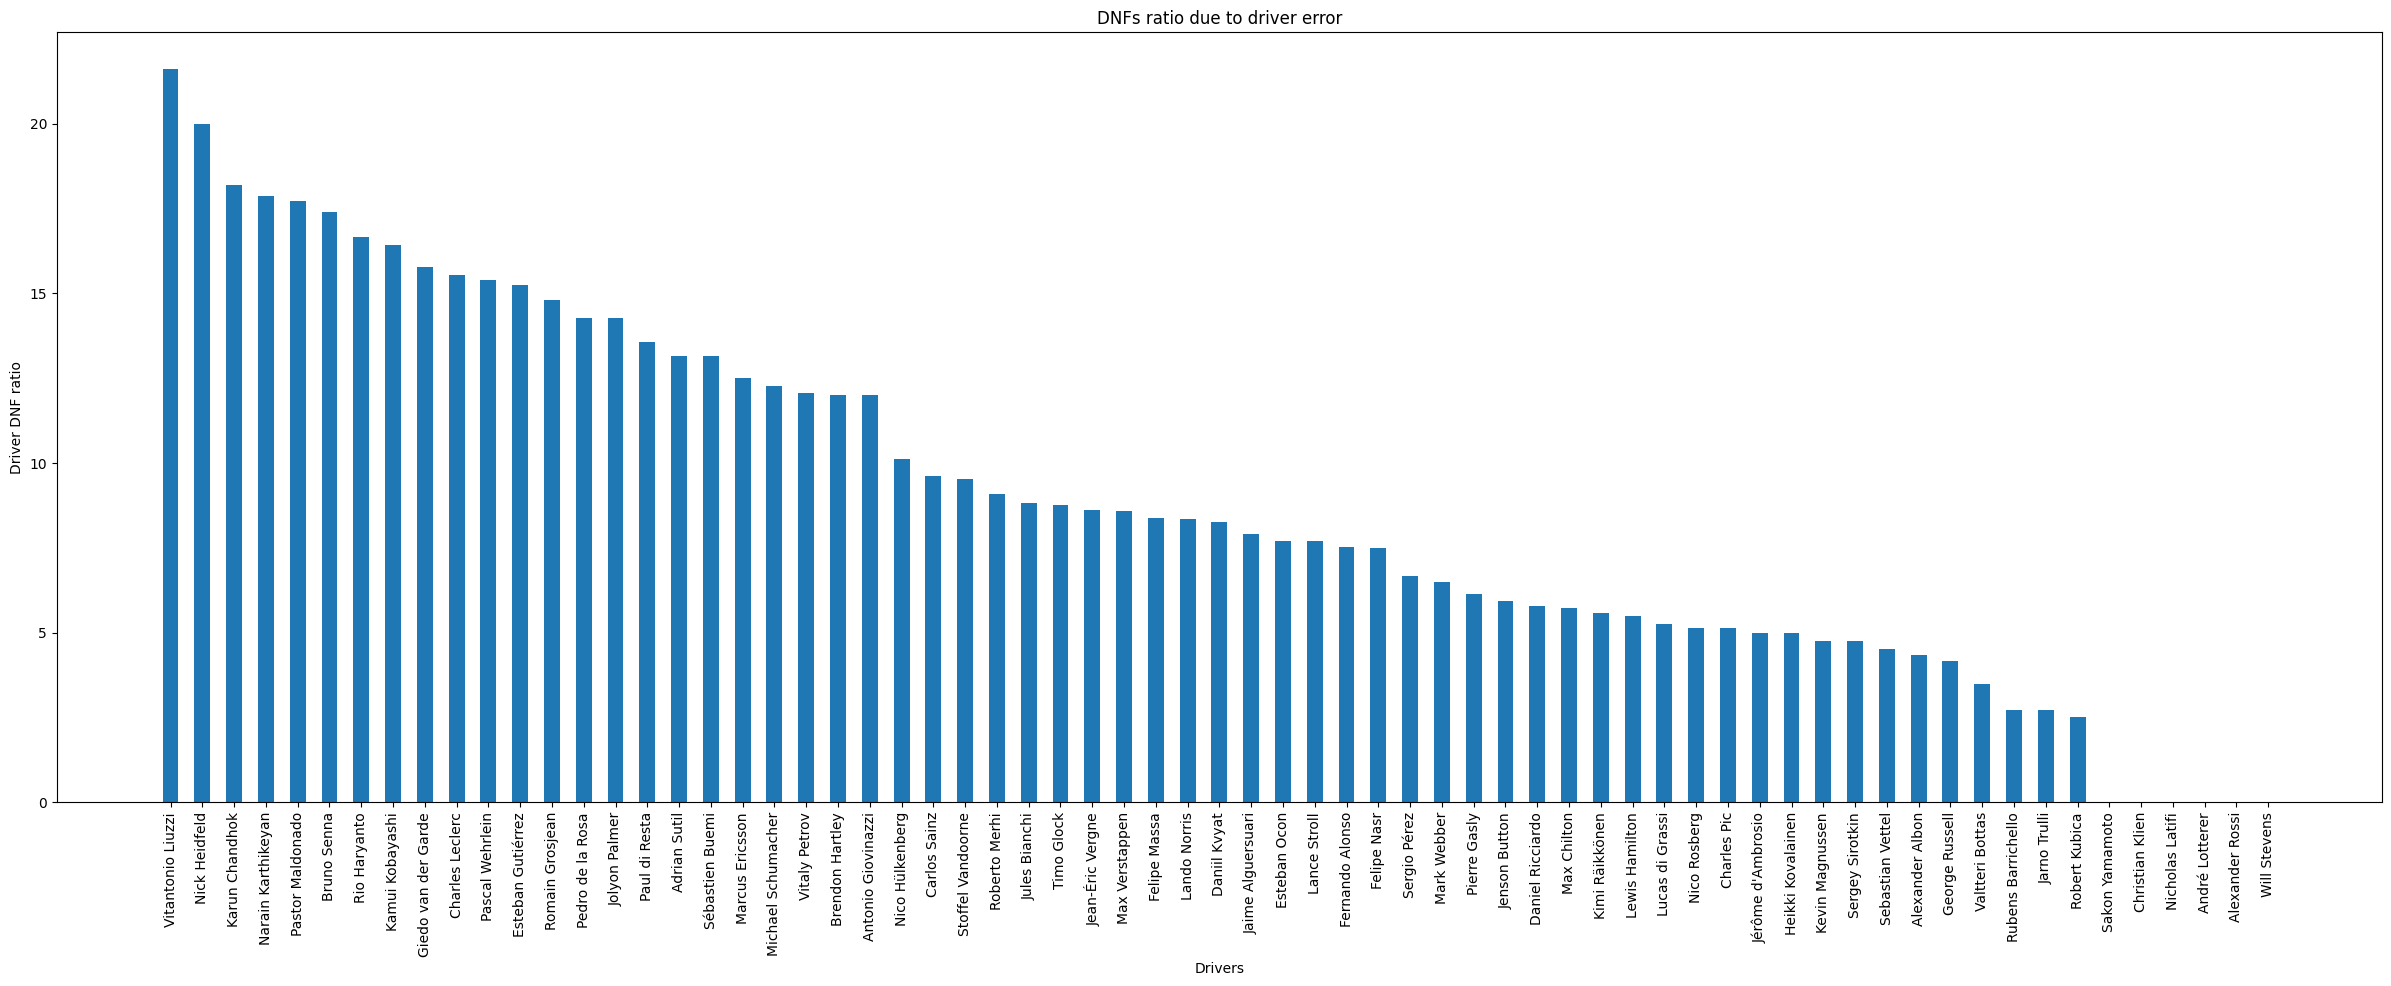

In [14]:
# the ratio of Did Not Finish (DNF) instances for each driver
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()
driver_race_entered = data.groupby('driver')['driver_dnf'].count()
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to driver error')
plt.show()

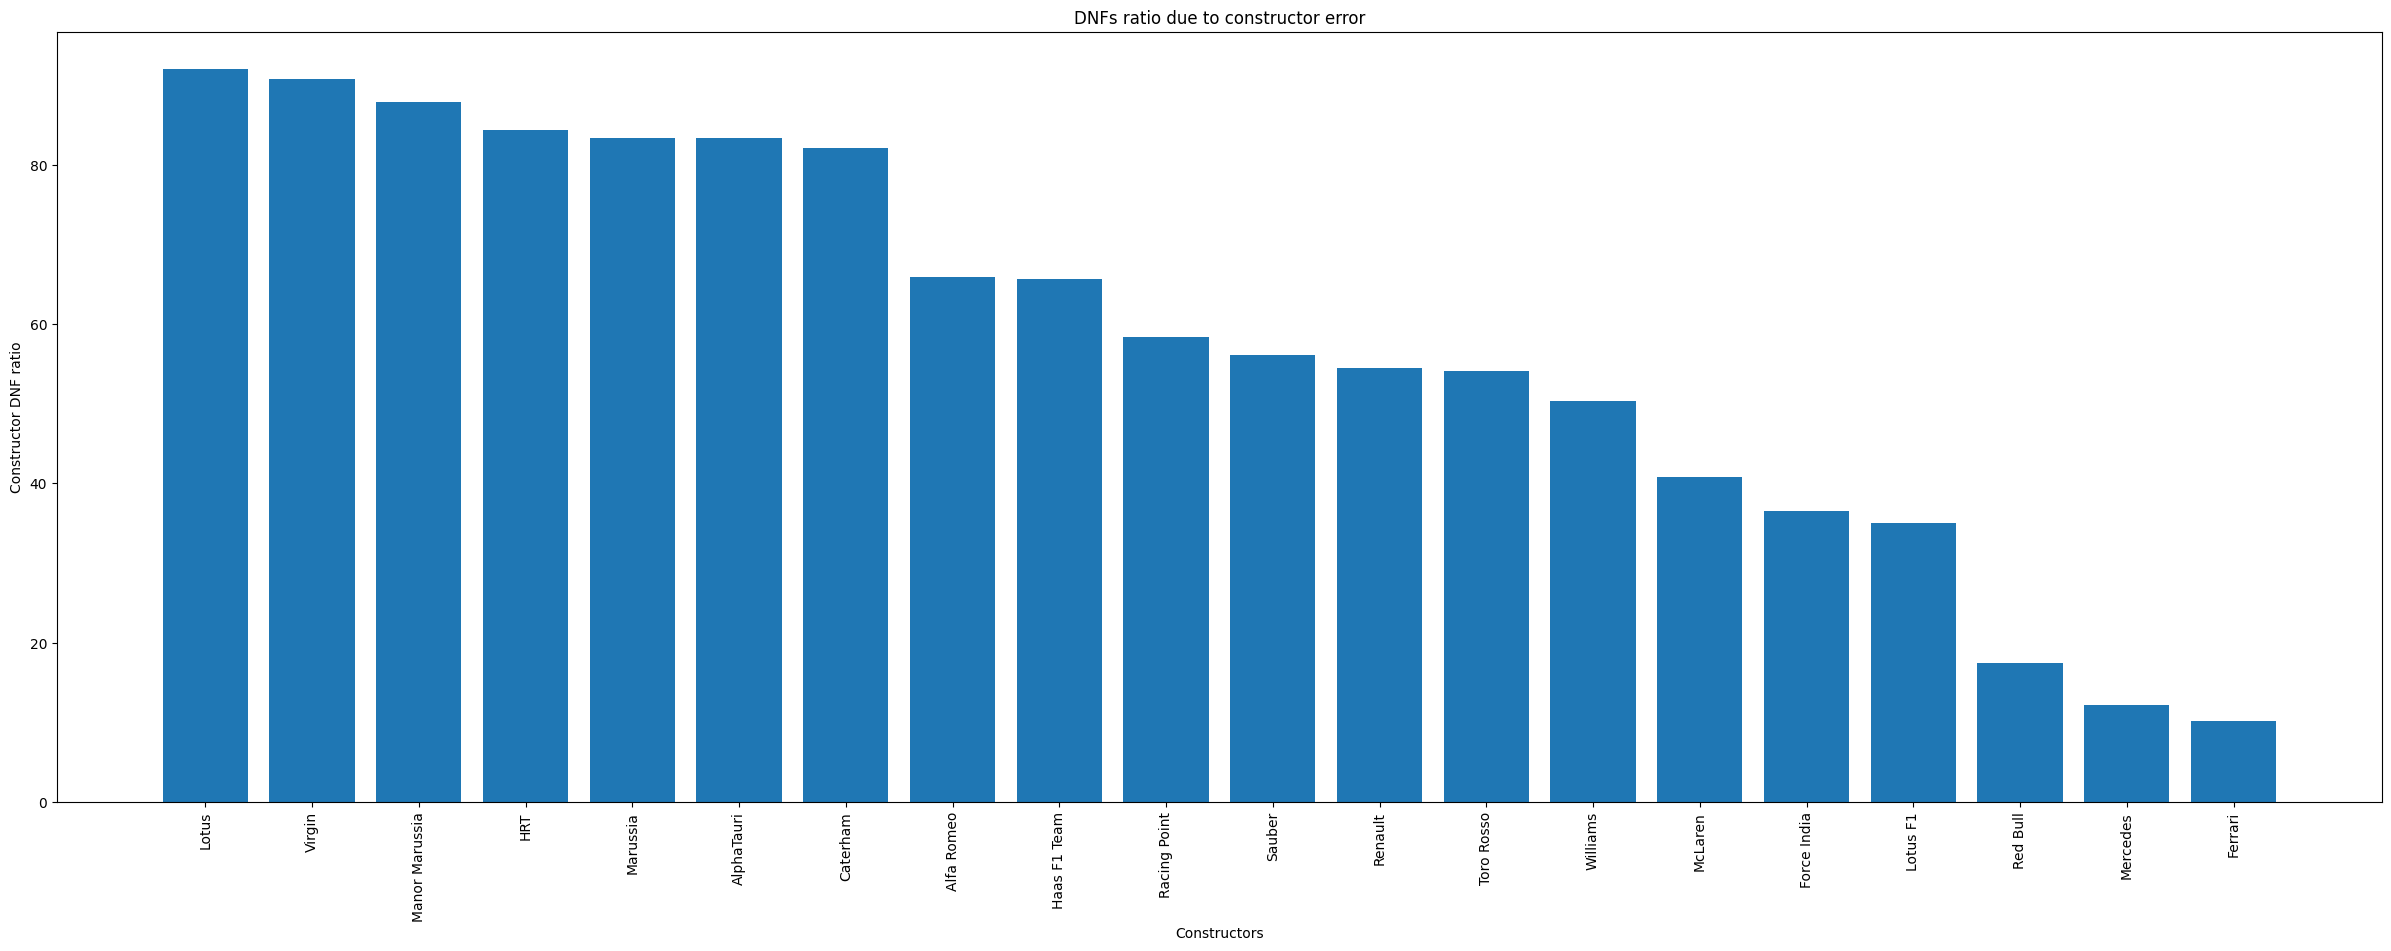

In [15]:
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()
constructor_race_entered = data.groupby('constructor')['constructor_dnf'].count()
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)

constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF ratio')
plt.title('DNFs ratio due to constructor error')

plt.show()

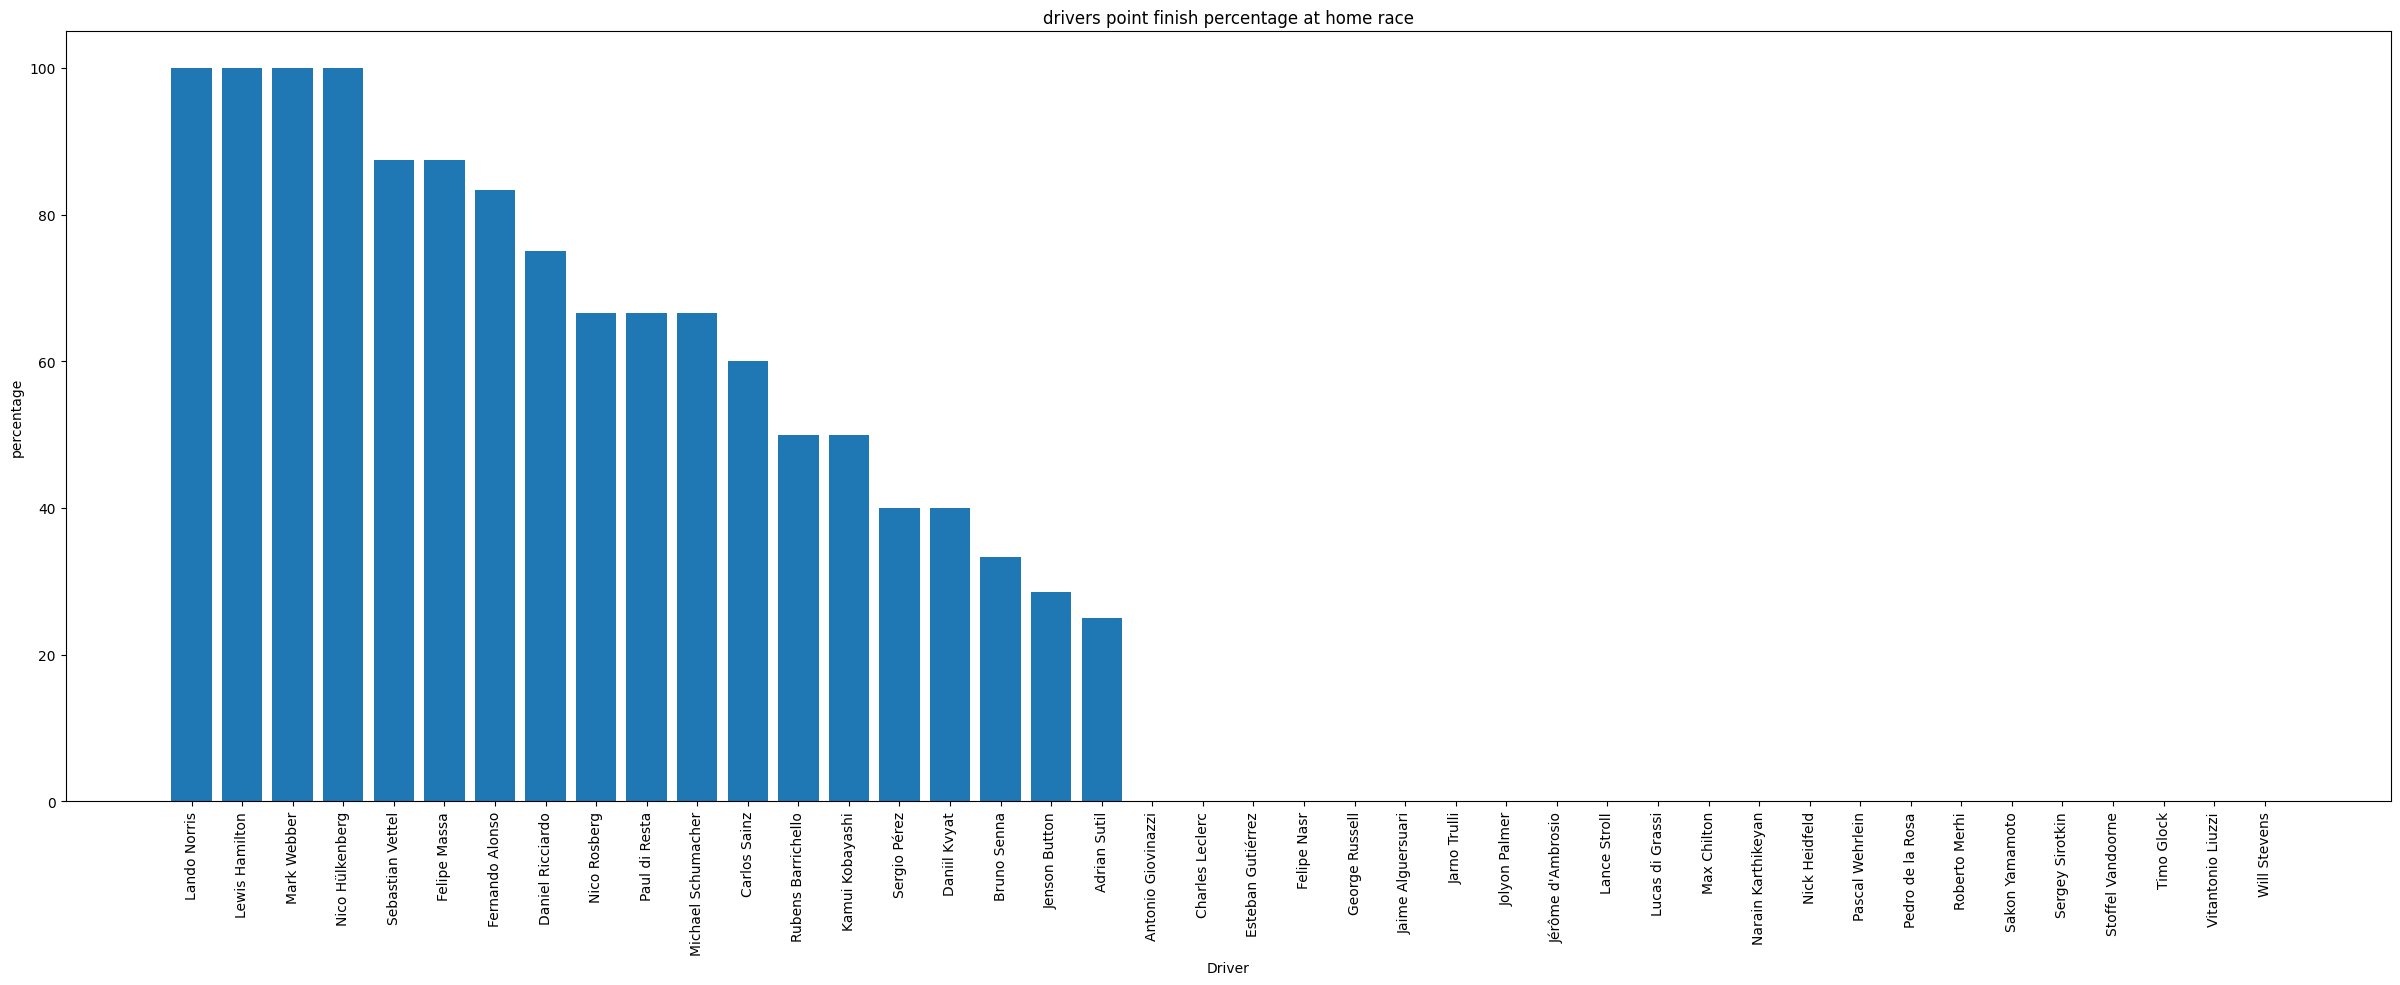

In [16]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver')['driver_home'].sum()
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('percentage')
plt.title('drivers point finish percentage at home race')

plt.show()

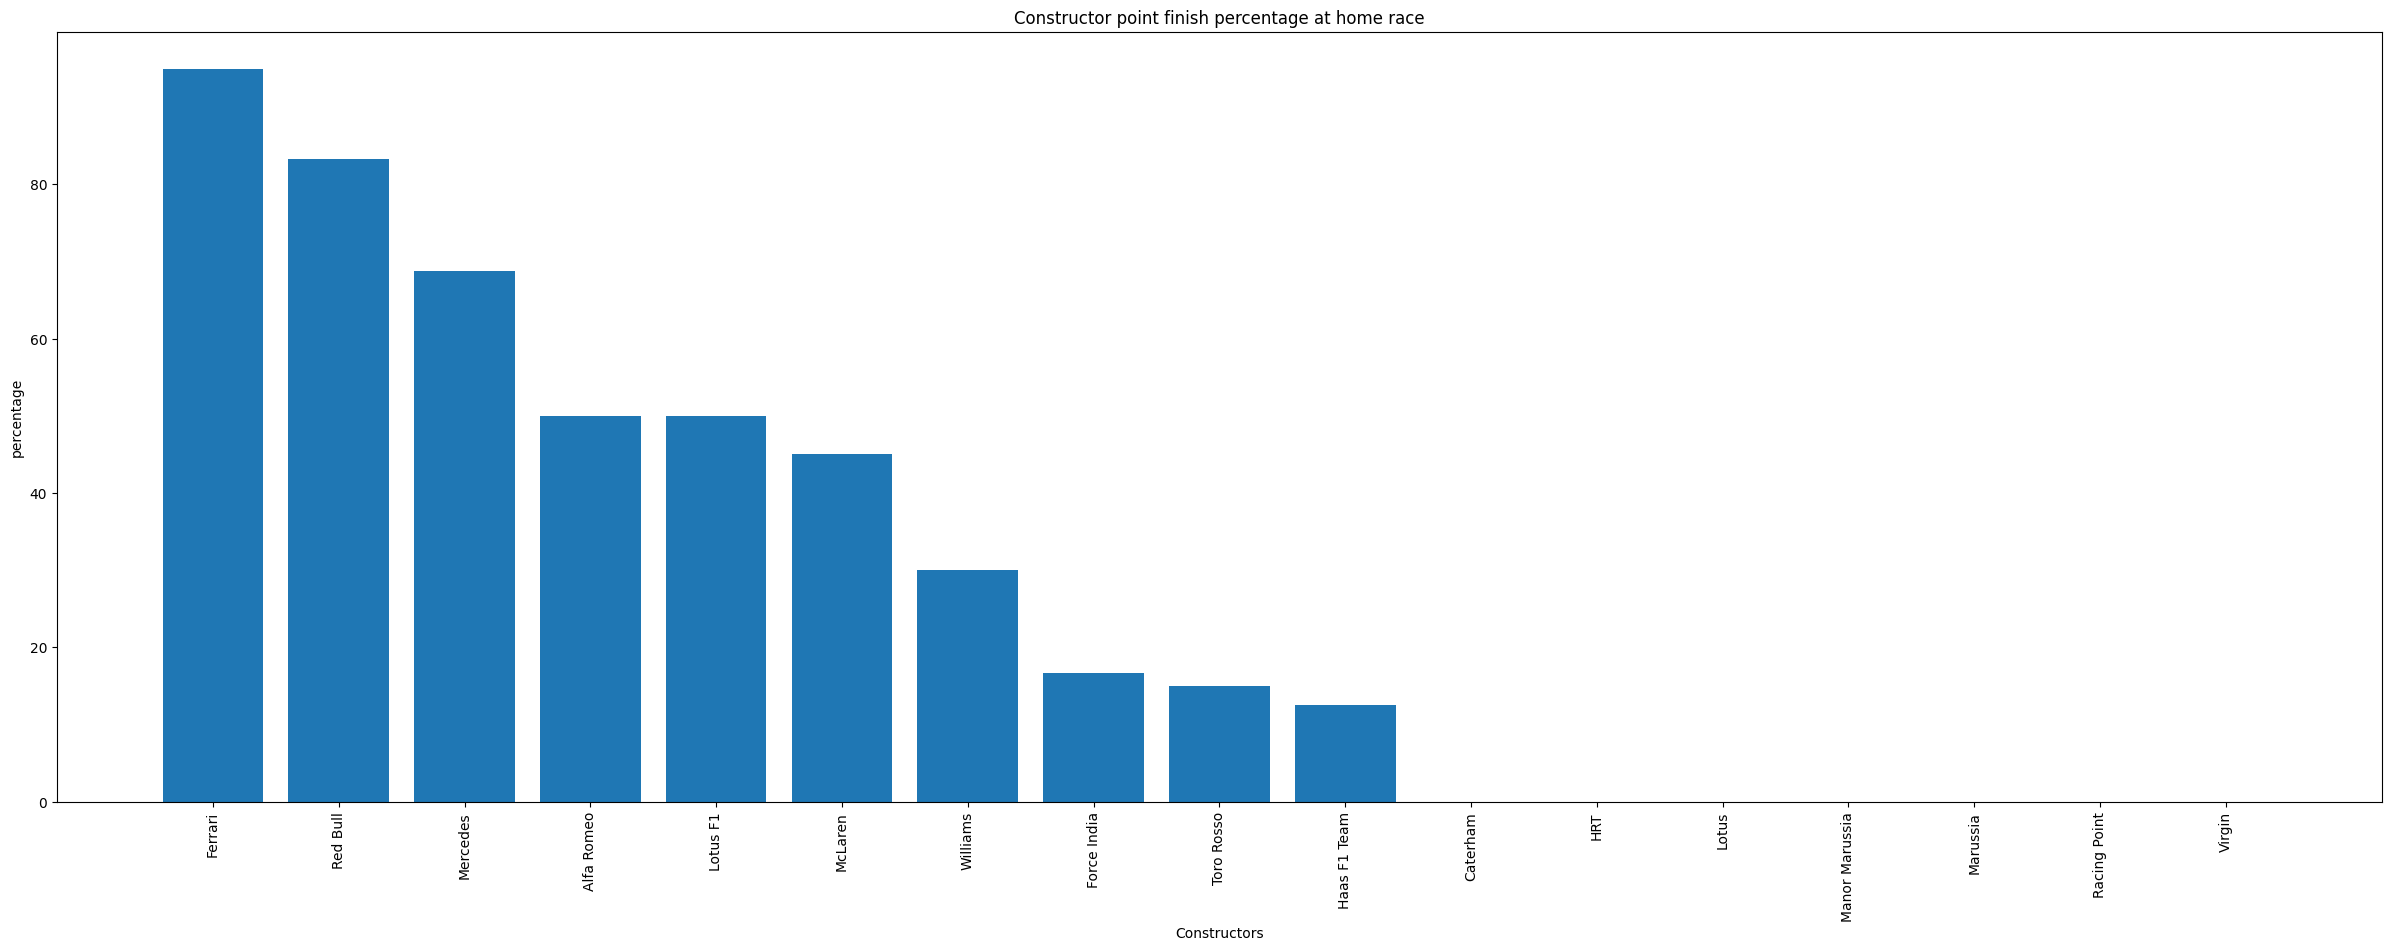

In [17]:
#top 10
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor')['constructor_home'].sum()
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor point finish percentage at home race')

plt.show()

**Feature Engineering:**

driver_confidence and constructor_relaiblity are new features added to quantify the confidence of drivers and reliability of constructors.


**Active Status Identification:**


The code creates binary indicators (active_driver and active_constructor) to identify whether drivers and constructors are currently active in the sport.


**Data Filtering:**
This setup can be useful for later filtering the dataset to focus only on active participants or for analyzing the performance of active drivers and constructors separately from those who have retired.

In [18]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])
#removing retired drivers and constructors
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [19]:
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('cleaned_data.csv',index=False)

In [20]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

sc  = StandardScaler()
le = LabelEncoder()
cleaned_data['GP_name'] = le.fit_transform(cleaned_data['GP_name'])
cleaned_data['constructor'] = le.fit_transform(cleaned_data['constructor'])
cleaned_data['driver'] = le.fit_transform(cleaned_data['driver'])
cleaned_data['GP_name'] = le.fit_transform(cleaned_data['GP_name'])
X = cleaned_data.drop(['position','active_driver','active_constructor','dob'],axis=1)
y = cleaned_data['position'].apply(lambda cleaned_data: position_index(cleaned_data))

In [21]:
print(X.dtypes)

GP_name                     int64
quali_pos                   int64
constructor                 int32
driver                      int32
driver_confidence         float64
constructor_relaiblity    float64
dtype: object


In [22]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle=True)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy',)
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

LogisticRegression : 0.880001057865228
DecisionTreeClassifier : 0.9163334391198562
RandomForestClassifier : 0.9330265524172221
SVC : 0.8748809901618534
GaussianNB : 0.8035808737966782
KNeighborsClassifier : 0.8428382524066433


C:\Users\TEST\AppData\Local\Temp\ipykernel_15184\765849455.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(x=results,labels=name)


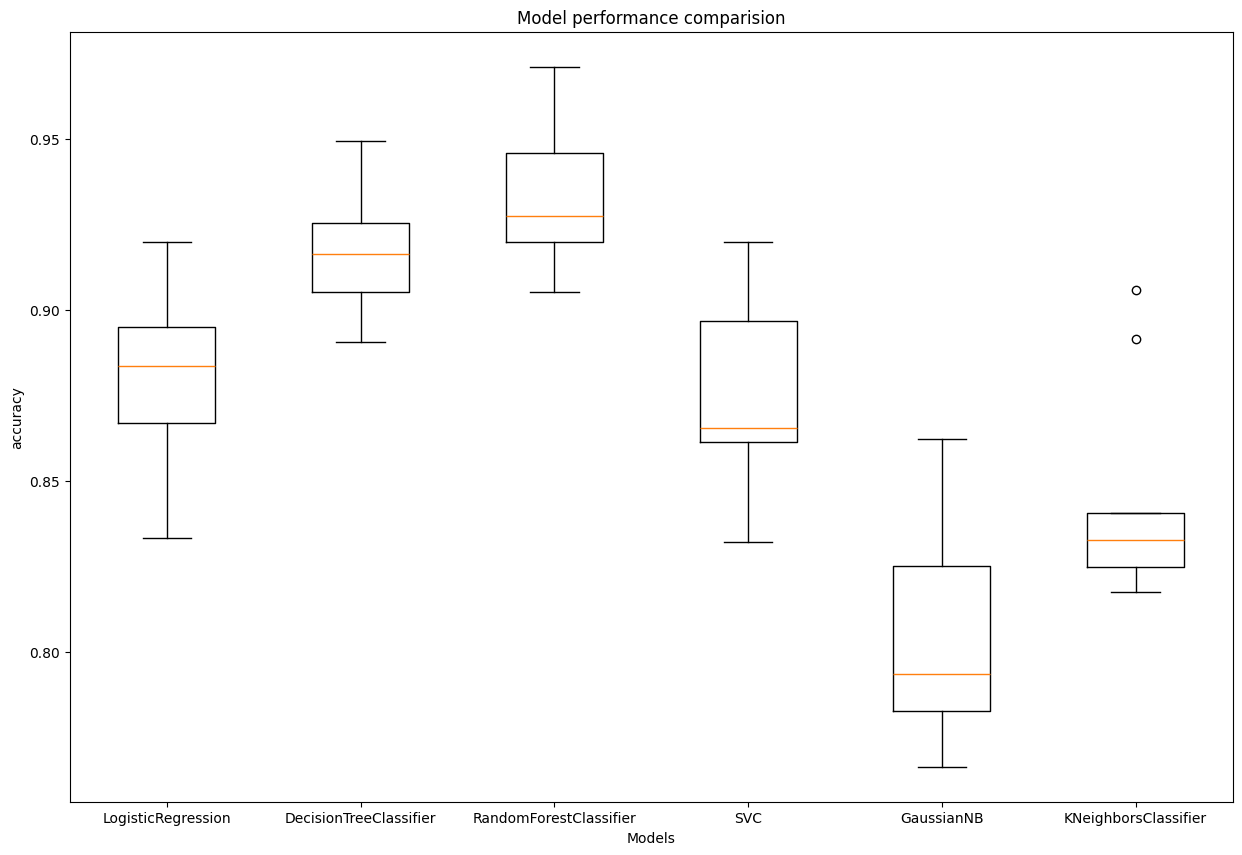

In [23]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

In [24]:
random_parms = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'min_samples_split': [2,5,8,10,15,20],
    'min_samples_leaf' : [1,2,4,6,8,10],
    'bootstrap': [True, False]
}

In [25]:
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=20,min_samples_leaf=1,max_features='sqrt',max_depth=90,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [26]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test,y_pred_rf)
cnf_mat_rf = cnf_mat_rf/cnf_mat_rf.sum()

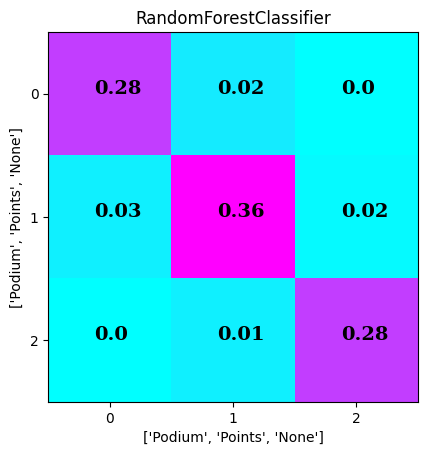

In [27]:
font3 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':14
}
plt.xticks(np.arange(3))
plt.yticks(np.arange(3))
plt.xlabel(['Podium','Points','None'])
plt.ylabel(['Podium','Points','None'])
plt.title('RandomForestClassifier')
im_rf = plt.imshow(cnf_mat_rf,cmap='cool')
for i in range(3):
    for j in range(3):
            plt.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)


In [28]:
rf_pression = precision_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test,y_pred_rf,average='macro')
rf_recall = recall_score(y_test,y_pred_rf,average='macro')
print(f'rf_pression : {rf_pression}')
print(f'rf_f1 : {rf_f1}')
print(f'rf_recall : {rf_recall}')

rf_pression : 0.9261270750359326
rf_f1 : 0.9221878505011034
rf_recall : 0.9191723663268379


In [29]:
import pickle

# Assuming your trained model is named 'rf_model'
with open('model.pkl', 'wb') as model_file:
    pickle.dump(rf, model_file)

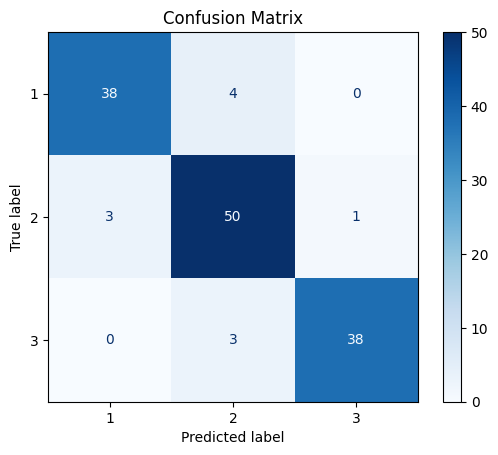

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming your model is called 'rf_model' and you have 'X_test' and 'y_test' data
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('static/confusion_matrix.png')
plt.show()


In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle


# Create LabelEncoders
gp_name_encoder = LabelEncoder()
constructor_encoder = LabelEncoder()
driver_encoder = LabelEncoder()

# Fit the encoders on the relevant columns
gp_name_encoder.fit(data['GP_name'])
constructor_encoder.fit(data['constructor'])
driver_encoder.fit(data['driver'])

# Save the encoders to .pkl files
with open('gp_name_encoder.pkl', 'wb') as file:
    pickle.dump(gp_name_encoder, file)

with open('constructor_encoder.pkl', 'wb') as file:
    pickle.dump(constructor_encoder, file)

with open('driver_encoder.pkl', 'wb') as file:
    pickle.dump(driver_encoder, file)
